**Goals of this notebook:**

Identify the following conditions of the sensor:
- dry
- connected lake
- disconnected lake
- overwash events

For now we would like to see:
- A time series of the pressure compared to tide times
- Detrended graphs of high tide conditions to see overwash events
- Zoom in Graphs of our main overwash events 

Questions:
- Why is the graph flucuating like it is? Is it due to tide times?
- How do we identify different conditions?
- How to download water level height, I have tried but is it the correct file??

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 18 09:55:59 2022

@author: pwiechen
"""
import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import root
import matplotlib.patches as pat
import matplotlib.dates as mdates
import pytz
#import netCDF4 as nc4
import scipy.signal
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.interpolate import griddata
from scipy.fftpack import fft    #importing Fourier transform package
from scipy.stats import chi2     #importing confidence interval package

from scipy.optimize import root


To get data for Air Pressure, visit the following site: https://www.daggegevens.knmi.nl/klimatologie/uurgegevens

- Get data from the period that the pressure sensors were deployed
- Select station 330 (Hoek van Holland)
- Select P: Air Pressure
- Save in the code file and input the path in the below code as stated

In [94]:
# Air pressure at Hoek van Holland

types_dict_ap = {'STN': str,'YYYYMMDD': str,'HH': float,'P': float}
air_pressure_raw = pd.read_csv(
    r'C:\Users\mscha\Documents\Stormtroopers\stormbenjamin\PS_Lake_Analysis\HVH_AirPressure_23102025_30102025.txt',
    skiprows=32,
    delimiter=',',
    skipinitialspace=True,
    usecols=[0,1,2,3],
    dtype=types_dict_ap,
    names=['STN','YYYYMMDD','HH','P']
    )

air_pressure_raw['time'] = np.zeros(len(air_pressure_raw['YYYYMMDD'].values))

for i in range(len(air_pressure_raw['time'])):
    air_pressure_raw['time'][i] = pd.to_datetime(air_pressure_raw['YYYYMMDD'].values[i], format="%Y%m%d") + timedelta(hours=air_pressure_raw['HH'].values[i])
   
air_pressure_raw.drop(columns=['YYYYMMDD', 'HH'], inplace=True)
air_pressure_HvH = air_pressure_raw[air_pressure_raw.STN.str.contains('330')]
air_pressure_HvH.rename(columns={"pressure":"pressure_HvH"}, inplace=True)

air_pressure_HvH['time'] = air_pressure_HvH['time'] + timedelta(seconds=3600)

air_pressure_HvH = air_pressure_HvH[air_pressure_HvH['time'] >= pd.Timestamp("2025-10-24 01:00:00")]

display(air_pressure_HvH)
#del i, types_dict_ap,  air_pressure_HvH, air_pressure_raw

#air_pressure_HvH.to_csv(r'C:/Users/kvand/Documents/Kevin/Civiele techniek/TU Delft/2.0 Master/Jaar 3/Q1/Fieldwork/DATA/RBR/dataset_air_pressure_HvHe_KNMI.csv')

C:\Users\mscha\AppData\Local\Temp\ipykernel_15480\2608996532.py:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  air_pressure_raw['time'][i] = pd.to_datetime(air_pressure_raw['YYYYMMDD'].values[i], format="%Y%m%d") + timedelta(hours=air_pre

,STN,P,time
2,330,9919.0,2025-10-24 01:00:00
3,330,9928.0,2025-10-24 02:00:00
4,330,9935.0,2025-10-24 03:00:00
5,330,9942.0,2025-10-24 04:00:00
6,330,9949.0,2025-10-24 05:00:00
...,...,...,...
166,330,10113.0,2025-10-30 21:00:00
167,330,10113.0,2025-10-30 22:00:00
168,330,10108.0,2025-10-30 23:00:00
169,330,10107.0,2025-10-31 00:00:00


Keep the following code as is, make sure to adjust rbr_data_reader for summer or winter time

In [95]:
def rbr_data_reader(file):
    
    '''
    Conversion of RBR file to workable dataframe. Note that the time is assumed to be CET,
    and therefore the conversion to time_unix subtracts 3600 s because the pd.to_numeric assumes GMT.
    
    BE CAREFUL! THIS FUNCTION ASSUMES WINTER TIME (UTC + 2HR)
    '''
    
    rbr_raw = pd.read_csv(file, parse_dates=['Time'])#, date_parser=dateparse_rbr)

    rbr = pd.DataFrame({
        'time':rbr_raw.Time,
        'time_unix': pd.to_numeric(rbr_raw.Time)/10**9-7200,  # If summertime subtract 7200 s
        'dt_s': np.arange(0,len(rbr_raw.Time)*0.125, 0.125),
        'pressure':rbr_raw.Pressure * 0.1 * 100000}) #dbar
    
    return rbr

def smooth(x,window_len,window):

    if x.ndim != 1:
        raise ValueError # "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError #"Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError #"Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[int(window_len/2-1):-int(window_len/2)]


def disper3(k,omega,h):
    g = 9.81
    return omega**2-g*k*np.tanh(k*h)

def p2sse(t,pressure,z_sensor, h_bed, cutoff):
    
    """
    Input:
        
        t: array with timestamps [s]
        pressure: array of the measured pressure [dbar]
        z_sensor: location of the sensor in coordinate system
        h_bed = distance from the bed (positive upward) [m]
        cutoff: cutoff frequency to avoid signal from blowing up [Hz]
        
    Output:
        eta: surface elevation timeseries
        eta_mean: mean water level
    """
    # Detrend the data using a smoothing function with a window of 15 minutes
    g = 9.81
    h = np.mean(pressure) + h_bed
    
    window_length = int(2*np.round(15*60/(t[1]-t[0])/2, decimals = 0))
    
    mean_pres = smooth(pressure, window_length, 'hanning') + np.mean(pressure - smooth(pressure, window_length, 'hanning'))
    mean = mean_pres*10000/(9.81*1025)
        
    pres_detrend = pressure - mean_pres
    
    plt.figure()
    plt.plot(t, pressure, label='Pressure signal')
    plt.plot(t, mean, label='Trend that is deleted within analysis')
    plt.grid()
    plt.legend()
    plt.show()
        
    # FFT stuff:
        
    delta_t = t[1]-t[0]
    nfft = len(t)
    D = (nfft)*delta_t
    fs = 1/(delta_t)
    df = 1/D
    f = np.arange(0,fs,df)
    
    Fpres = np.fft.fft(pres_detrend,nfft)/nfft
    
    # Avoid problem with np.arange (normally last value is not included)
    if len(f) != len(Fpres):
        f = f[:-1]
        
    k_linear = np.zeros(len(f))
    
    # initial estimate of k using Eckart 1952
    alpha = 4*np.pi**2*h/(g*(1/f[1])**2)
    k_linear_previous = alpha/h * np.sqrt(np.cosh(alpha)/np.sinh(alpha))
        
    for i in range(len(f)):
        
        #print(100*np.round((i+1)/len(f),decimals = 2), ' % progress')
        
        if i > 0:
            k_linear_sol = root(disper3,k_linear_previous, args=(2*np.pi*f[i],h), method = 'lm')
            k_linear[i] = k_linear_sol.x
            k_linear_previous = k_linear_sol.x
        if k_linear_previous < 0:
            k_linear_previous = 0.0001
            print('Caution, negative k-value found in iteration for frequency: ', f[i], ' Hz')
    
    cutoff_index_begin = int(np.argwhere(f>=cutoff)[0])  
    cutoff_index_end = int(np.argwhere(f>=f[-1] - cutoff)[0]) 
    k_linear[cutoff_index_begin:] = 1 
    
    if h_bed >= 0:
        factor =  np.cosh(k_linear*h)/(np.cosh(k_linear*h_bed))
    else:
        factor = np.cosh(k_linear*h)/(np.exp(k_linear*h_bed))
        
    k_linear[0] = k_linear[1] # Replace to avoid a divide by zero error
    factor[0] = 1
    
    # Use method of Bishop and Donelan 1987
    
    L = 2*np.pi/k_linear
    dS = h - h_bed
    maxFactor = 0.2
    
    factor[np.argwhere(dS/L > maxFactor)] = np.max(factor[np.argwhere(dS/L <= maxFactor)])
   
    cutoff_index_begin = int(np.argwhere(f>=cutoff)[0])  
    cutoff_index_end = int(np.argwhere(f>=f[-1] - cutoff)[0]) 
    
    factor[cutoff_index_begin:cutoff_index_end] = 0 
    
    factor[cutoff_index_end:] = np.flip(factor[1:cutoff_index_begin+1])
    
    Fnew = factor*Fpres
    
    eta = np.real(np.fft.ifft(Fnew,nfft)*nfft)
    eta_mean = mean + z_sensor
    
    return eta, eta_mean

Add the data file for the pressure sensor here

In [ ]:
## Load rbr data

rbr_01 = rbr_data_reader(r'C:\Users\mscha\Documents\Stormtroopers\stormbenjamin\PS_Lake_Analysis\PressureSensor RBR\202438_20251031_1250_stormtroopers Oct 2025\202438_20251031_1250_stormtroopers Oct 2025_data.txt')

In [ ]:
## Air pressure

start_exp = pd.to_datetime("2025-10-24 12:00:00")
end_exp   = pd.to_datetime("2025-10-30 12:00:00")

start_time = datetime(2025,10,26,4,55,0).timestamp()
end_time = datetime(2025,10,26,5,25,0).timestamp()

air_pres_int = (air_pressure_HvH.loc[air_pressure_HvH['time'] == start_exp, 'P'].iloc[0] + air_pressure_HvH.loc[air_pressure_HvH['time'] == end_exp, 'P'].iloc[0]) / 2

air_pres = air_pres_int * 10 #bar to Pa

This cell is used to show the time series of the pressure

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 [Text(0, -500.0, '−500'),
  Text(0, 0.0, '0'),
  Text(0, 500.0, '500'),
  Text(0, 1000.0, '1000'),
  Text(0, 1500.0, '1500'),
  Text(0, 2000.0, '2000'),
  Text(0, 2500.0, '2500'),
  Text(0, 3000.0, '3000')])

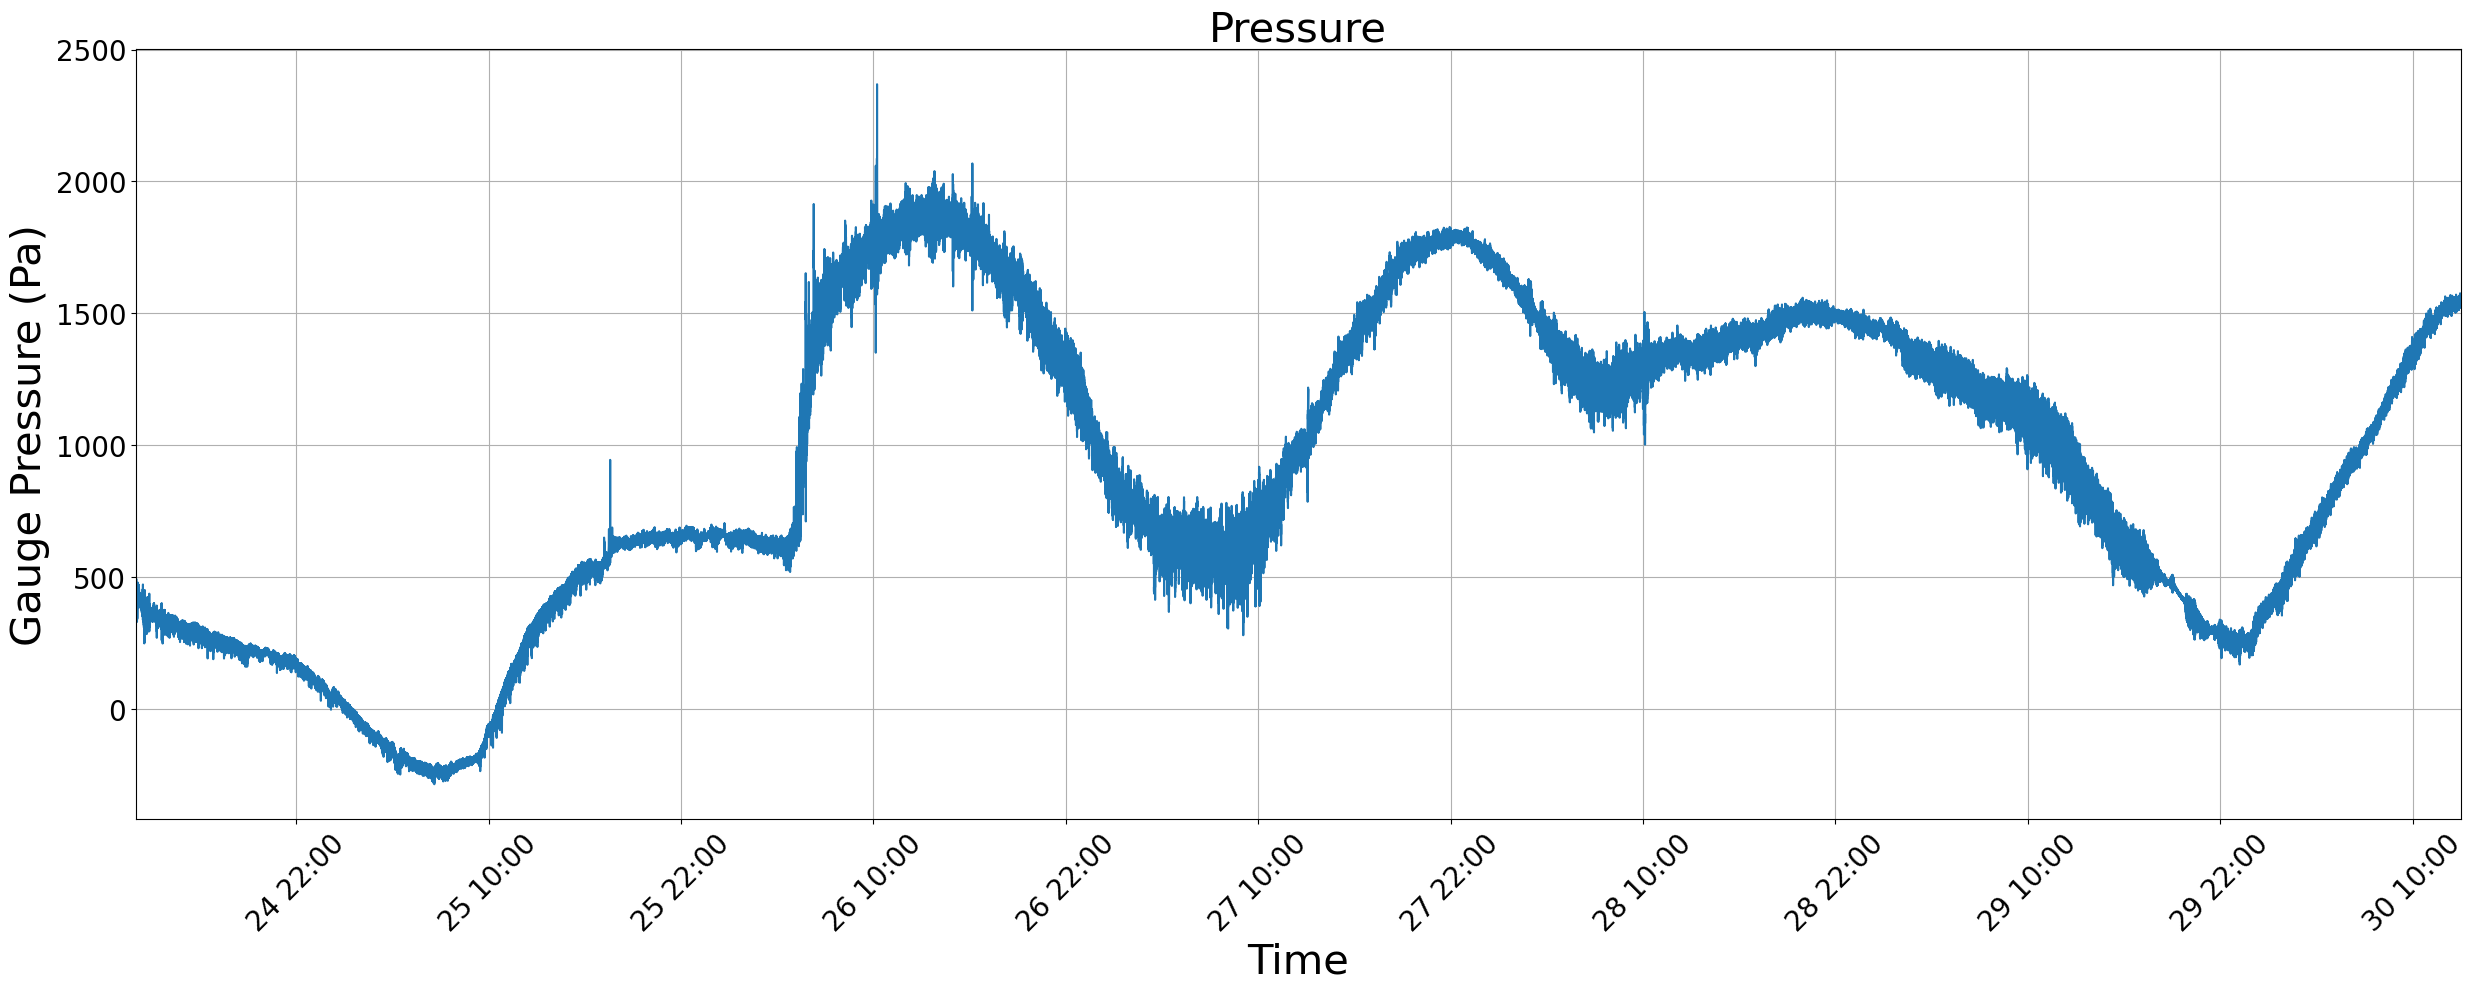

In [93]:
## Time Series of the Pressure from start time to end time

start_time_24_30 = datetime(2025,10,24,0,0,0).timestamp()
end_time_24_30 = datetime(2025,10,30,12,0,0).timestamp()

index_start_24_30 = np.where(rbr_01['time_unix'] >= start_time_24_30)[0][0]
index_end_24_30 = np.where(rbr_01['time_unix'] > end_time_24_30)[0][0]


plt.figure(1,figsize=(30,10))
plt.plot(rbr_01['time'], rbr_01['pressure'] - air_pres, label='RBR Sensor 1')
plt.xlabel('Time', fontsize=30)
plt.ylabel('Gauge Pressure (Pa)', fontsize=30)
plt.grid()
plt.xlim(rbr_01['time'][index_start_24_30], rbr_01['time'][index_end_24_30])

# Hourly ticks; show day and hour:minute (e.g. '26 04:55') 

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
plt.title('Pressure', fontsize=30)
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)

## Add water level to the plot

Lets create a plot below on the same axis of the tides to compare how our pressure is changing in respect to the tides

In [ ]:
# Time series of the Pressure for the 24th of October 2025
start_time_24 = datetime(2025,10,24,12,0,0).timestamp()
end_time_24 = datetime(2025,10,25,0,0,0).timestamp()

index_start_24 = np.where(rbr_01['time_unix'] >= start_time_24)[0][0]
index_end_24 = np.where(rbr_01['time_unix'] > end_time_24)[0][0]

plt.figure(1,figsize=(15,5))
plt.plot(rbr_01['time'][index_start_24:index_end_24], rbr_01['pressure'][index_start_24:index_end_24] - air_pres, label='RBR Sensor 1')
plt.xlabel('Time')          
plt.ylabel('Gauge Pressure (Pa)')
plt.xlim(rbr_01['time'][index_start_24], rbr_01['time'][index_end_24])
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
plt.title('Pressure')
plt.xticks(rotation=45)
plt.tight_layout()

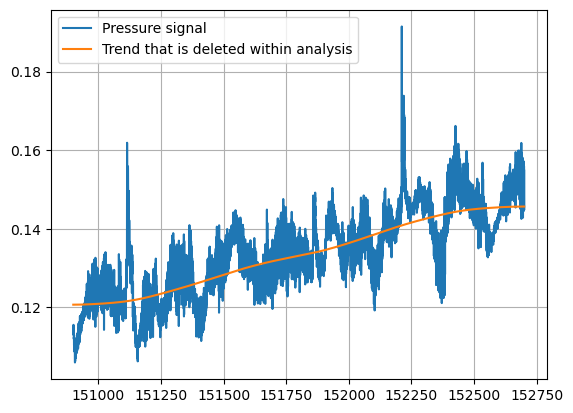

C:\Users\mscha\AppData\Local\Temp\ipykernel_15480\3443346928.py:111: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_linear[i] = k_linear_sol.x
C:\Users\mscha\AppData\Local\Temp\ipykernel_15480\3443346928.py:117: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cutoff_index_begin = int(np.argwhere(f>=cutoff)[0])
C:\Users\mscha\AppData\Local\Temp\ipykernel_15480\3443346928.py:118: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cutoff_index_end = int(np.argwhere(f>=f[-1]

In [14]:
##Convert from pressure to surface elevation
start_time = datetime(2025,10,26,4,55,0).timestamp()
end_time = datetime(2025,10,26,5,25,0).timestamp()

index_start = np.where(rbr_01['time_unix'] >= start_time)[0][0]
index_end = np.where(rbr_01['time_unix'] > end_time)[0][0]

z_sensor_rbr01 = 4.067          #NAP
h_bed_rbr01    = 0.22           # Height of Sensor above bed

#z_sensor_rbr02 = 0.626 - 0.21 #NAP
#h_bed_rbr02 = 0.05

#z_sensor_rbr03 = 0.289 - 0.21 #NAP
#h_bed_rbr03 = 0.34

#z_sensor_rbr04 = -1.238 - 0.21 #NAP
#h_bed_rbr04 = 0.19

rbr_01_eta, rbr_01_eta_mean = p2sse(rbr_01['dt_s'].values[index_start:index_end], (rbr_01['pressure'].values[index_start:index_end] - air_pres)/10000, z_sensor_rbr01, h_bed_rbr01, 1)
#rbr_02_eta, rbr_02_eta_mean = p2sse(rbr_02['dt_s'].values[index_start:index_end], (rbr_02['pressure'].values[index_start:index_end] - air_pres)/10000, z_sensor_rbr02, h_bed_rbr02, 1)
#rbr_03_eta, rbr_03_eta_mean = p2sse(rbr_03['dt_s'].values[index_start:index_end], (rbr_03['pressure'].values[index_start:index_end] - air_pres)/10000, z_sensor_rbr03, h_bed_rbr03, 1)
#rbr_04_eta, rbr_04_eta_mean = p2sse(rbr_04['dt_s'].values[index_start:index_end], (rbr_04['pressure'].values[index_start:index_end] - air_pres)/10000, z_sensor_rbr04, h_bed_rbr04, 1)

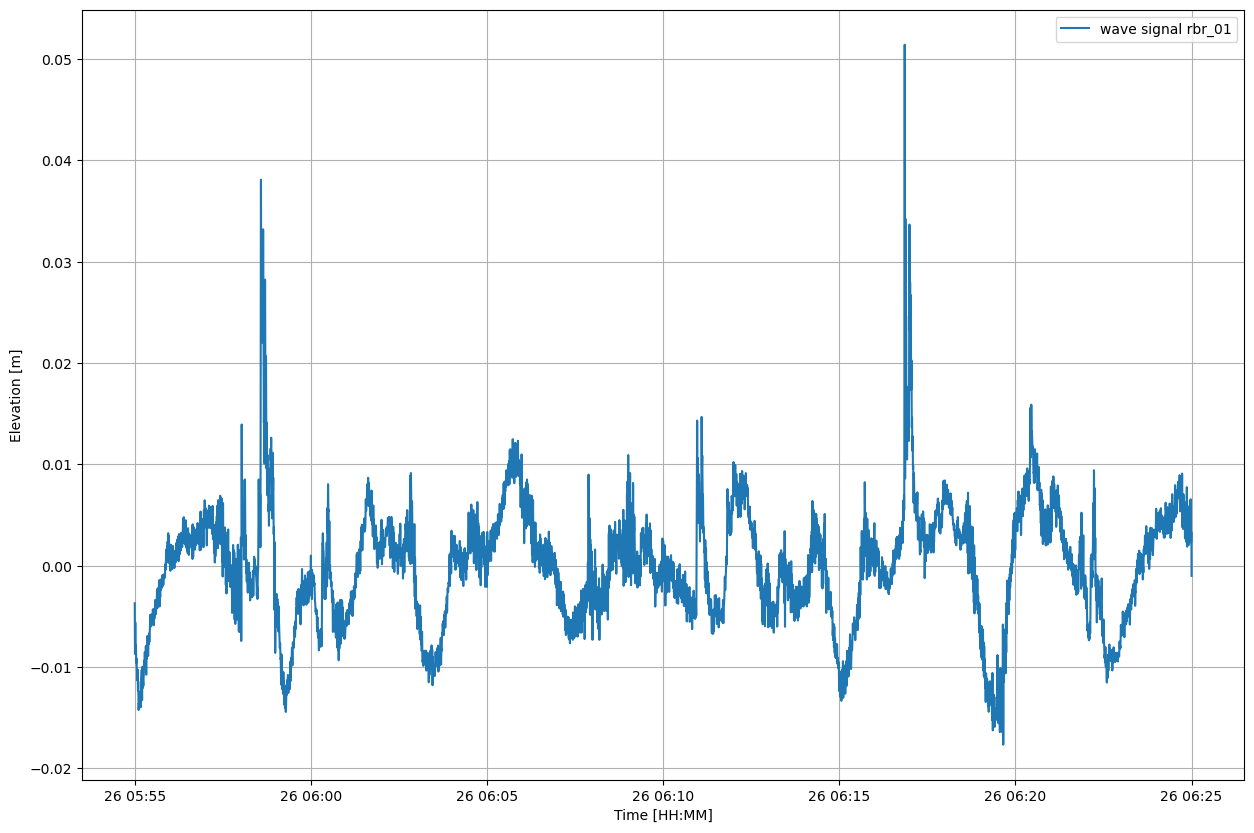

In [86]:
plt.figure(figsize = (15, 10))

plt.plot(rbr_01['time'][index_start:index_end], rbr_01_eta, label='wave signal rbr_01')
#plt.plot(rbr_01['time'][index_start:index_end], rbr_01_eta_mean, label='mean signal rbr_01 wrt NAP')

plt.xlabel('Time [HH:MM]')
plt.ylabel('Elevation [m]')

plt.grid()
plt.legend()
 

Ignore wave sprectrum analysis for now

In [9]:
def wave_spectrum(data,nfft,Fs):
    ''' Compute variance spectral density spectrum of the time-series and its 
    90% confidence intervals. 
    The time-series is first divided into blocks of length nfft before being 
    Fourier-transformed.

    INPUT
      data    timeseries 
      nfft    block length
       Fs     sampling frequency (Hz)
    
    OUTPUT
      E       variance spectral density. If data is in meters, E is in m^2/Hz
      f       frequency axis (Hz)
      confLow and confUpper     Lower and upper 90% confidence interval; 
                                (Multiplication factors for E)  '''
    
    # 1. PRELIMINARY CALCULATIONS
    # ---------------------------
    n = len(data)                # length of the time-series
    nfft = int(nfft - (nfft%2))  # the length of the window should be an even number

    data = scipy.signal.detrend(data)      # detrend the time-series
    nBlocks = int(n/nfft)        # number of blocks (use of int to make it an integer)

    data_new = data[0:nBlocks*nfft] # (we work only with the blocks which are complete)

    # we organize the initial time-series into blocks of length nfft 
    dataBlock = np.reshape(data_new,(nBlocks,nfft))  # each column of dataBlock is one block
    
    # 2. CALCULATION VARIANCE DENSITY SPECTRUM
    # ----------------------------------------

    # definition frequency axis
    df = Fs/nfft      # frequency resolution of the spectrum df = 1/[Duration of one block]
    f = np.arange(0,Fs/2+df,df)   # frequency axis (Fs/2 = Fnyquist = max frequency)
    fId = np.arange(0,len(f))

    # Calculate the variance for each block and for each frequency
    fft_data = fft(dataBlock,n = nfft,axis = 1)      # Fourier transform of the data 
    fft_data = fft_data[:,fId]            # Only one side needed
    A = 2.0/nfft*np.real(fft_data)          # A(i,b) and B(i,b) contain the Fourier coefficients Ai and Bi for block b
    B = 2.0/nfft*np.imag(fft_data)          #  -- see LH's book, page 325 for definition of Ai and Bi
                                          # /!\ assumes that mean(eta)=0 

    E = (A**2 + B**2)/2.                  # E(i,b) = ai^2/2 = variance at frequency fi for block b. 

    # We finally average the variance over the blocks, and divide by df to get the variance DENSITY spectrum
    E = np.mean(E, axis = 0)/df
    
    # 3. CONFIDENCE INTERVALS
    # -----------------------
    edf = round(nBlocks*2)   # Degrees of freedom 
    alpha = 0.1              # calculation of the 90% confidence interval

    confLow = edf/chi2.ppf(1-alpha/2,edf)    # see explanations on confidence intervals given in lecture 3 
    confUpper  = edf/chi2.ppf(alpha/2,edf)
    
    return E,f,confLow,confUpper

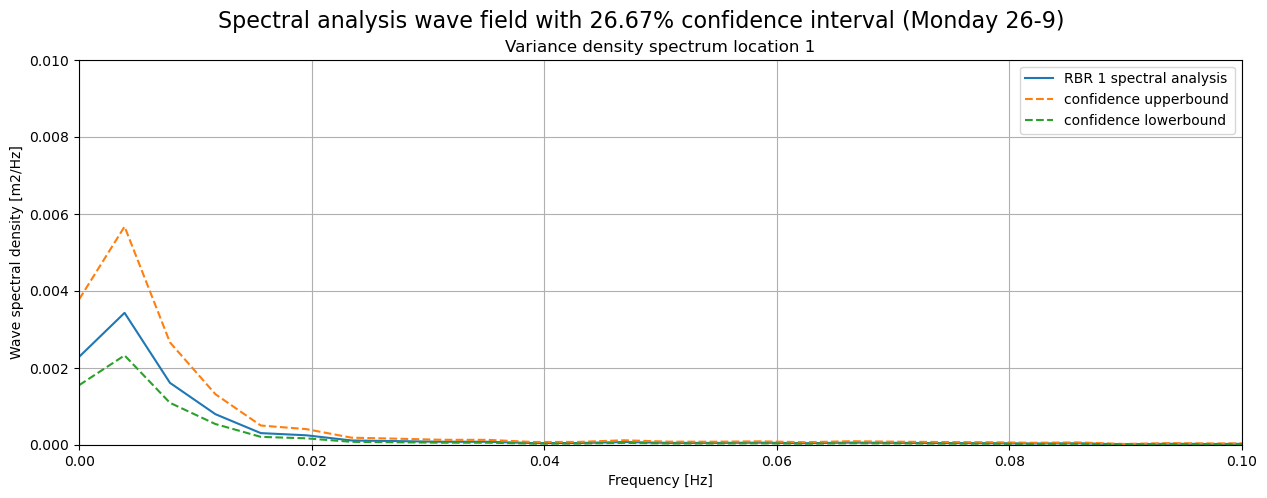

In [10]:
n = 1024                                    #number of subblocks
error = 100/np.sqrt(len(rbr_01_eta)/n)
#print(error)
#print(n)

fig = plt.figure(figsize=(15, 5))
fig.suptitle(f"Spectral analysis wave field with {error:.2f}% confidence interval (Monday 26-9)", fontsize=16)

E1, f1, Conflow, Confupper = wave_spectrum(rbr_01_eta, n, 4)
plt.plot(f1, E1, label = 'RBR 1 spectral analysis')
plt.plot(f1, Confupper * E1, label = 'confidence upperbound', ls='--')
plt.plot(f1, Conflow * E1, label = 'confidence lowerbound', ls='--')
plt.xlim([0, 0.1])
plt.ylim([0, 0.01])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Wave spectral density [m2/Hz]')
plt.grid()
plt.title("Variance density spectrum location 1")
plt.legend()

# plt.savefig("Spectral analysis wave field Monday 26-9.jpg")


In [11]:
delta_omega = f1[1]-f1[0]

# RBR 1
start = 0.0
stop = 1

integrated_value1 = 0
for index, frequency in enumerate(f1):
    if (frequency >= start) and (frequency <= stop):
        integrated_value1 += E1[index]*delta_omega
Hs1 = 4*np.sqrt(integrated_value1)
print('Hs RBR1 =', round(Hs1,2),'m') 


Hs RBR1 = 0.03 m


In [12]:
# RBR 1
# start = 0
# stop = 1

integrated_value1 = 0
for index, frequency in enumerate(f1):
    if (frequency >= start) and (frequency <= stop):
        integrated_value1 += E1[index]*delta_omega
Hs1 = 4*np.sqrt(integrated_value1)
print('Hs RBR1 =', round(Hs1,3),'m') 

# upperbound
integrated_value11 = 0
for index, frequency in enumerate(f1):
    if (frequency >= start) and (frequency <= stop):
        integrated_value11 += (Confupper * E1[index])*delta_omega
Hs_upper = 4*np.sqrt(integrated_value11)
print('Hs RBR1 upperbound =', round(Hs_upper,3),'m') 

# Lowerbound
integrated_value12 = 0
for index, frequency in enumerate(f1):
    if (frequency >= start) and (frequency <= stop):
        integrated_value12 += (Conflow * E1[index])*delta_omega
Hs_upper = 4*np.sqrt(integrated_value12)
print('Hs RBR1 Lowerbound =', round(Hs_upper,3),'m') 

Hs RBR1 = 0.026 m
Hs RBR1 upperbound = 0.034 m
Hs RBR1 Lowerbound = 0.021 m


In [13]:
# RBR 3
# start = 0
# stop = 1

integrated_value3 = 0
for index, frequency in enumerate(f3):
    if (frequency >= start) and (frequency <= stop):
        integrated_value3 += E3[index]*delta_omega
Hs3 = 4*np.sqrt(integrated_value3)
print('Hs RBR3 =', round(Hs3,2),'m') 

# upperbound
integrated_value31 = 0
for index, frequency in enumerate(f1):
    if (frequency >= start) and (frequency <= stop):
        integrated_value31 += (Confupper3 * E3[index])*delta_omega
Hs_upper = 4*np.sqrt(integrated_value31)
print('Hs RBR3 upperbound =', round(Hs_upper,2),'m') 

# Lowerbound
integrated_value32 = 0
for index, frequency in enumerate(f1):
    if (frequency >= start) and (frequency <= stop):
        integrated_value32 += (Conflow3 * E3[index])*delta_omega
Hs_upper = 4*np.sqrt(integrated_value32)
print('Hs RBR3 Lowerbound =', round(Hs_upper,2),'m') 


NameError: name 'f3' is not defined

In [ ]:
#  RBR 4
# start = 0
# stop = 1

integrated_value4 = 0
for index, frequency in enumerate(f4):
    if (frequency >= start) and (frequency <= stop):
        integrated_value4 += E4[index]*delta_omega
Hs4 = 4*np.sqrt(integrated_value4)
print('Hs RBR4 =', round(Hs4,2),'m')

# upperbound
integrated_value41 = 0
for index, frequency in enumerate(f1):
    if (frequency >= start) and (frequency <= stop):
        integrated_value41 += (Confupper4 * E4[index])*delta_omega
Hs_upper = 4*np.sqrt(integrated_value41)
print('Hs RBR4 upperbound =', round(Hs_upper,2),'m') 

# Lowerbound
integrated_value42 = 0
for index, frequency in enumerate(f1):
    if (frequency >= start) and (frequency <= stop):
        integrated_value42 += (Conflow4 * E4[index])*delta_omega
Hs_upper = 4*np.sqrt(integrated_value42)
print('Hs RBR4 Lowerbound =', round(Hs_upper,2),'m') 

Hs RBR4 = 1.22 m
Hs RBR4 upperbound = 1.46 m
Hs RBR4 Lowerbound = 1.05 m


In [ ]:
len_data = len(rbr_01_eta)
nan_count = np.isnan(rbr_01_eta).sum()
sample_dt = np.median(np.diff(rbr_01['time'].astype('int64')/1e9))  # seconds
print(len_data, nan_count, sample_dt)

print(index_start, index_end, index_end-index_start)

data_len = len(rbr_01_eta)
chosen_nfft = 1024   # or whatever you pass into wave_spectrum
print('data_len', data_len, 'nfft', chosen_nfft, 'nBlocks', data_len // chosen_nfft)

14401 0 0.125
484800 499201 14401
data_len 14401 nfft 1024 nBlocks 14
